In [86]:
from octis.dataset.dataset import Dataset

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# sns.set_theme()

import os
import subprocess

from rich.console import Console
from rich.table import Table

# Fetching the datasets

In [87]:
def fetch_dataset_from_octis(dataset_name: str, keywords: dict):
    """ Fetches a dataset from OCTIS and saves it in the datasets folder.

    Args:
        dataset_name (str): Name of the dataset.
        keywords (dict): Keywords associated to each class.
    """
    dataset = Dataset()
    dataset.fetch_dataset(dataset_name)

    df = pd.DataFrame()

    # Documents and classes
    df['document'] = [' '.join(item) for item in dataset.get_corpus()]

    df['class_name'] = dataset.get_labels()
    true_topics = list(set(dataset.get_labels()))
    class_index = [true_topics.index(label) for label in df['class_name']]
    df['class_index'] = class_index

    # Separate train and test
    train_df = df.sample(frac=0.8, random_state=42)
    train_df['dataset_type'] = 'train'

    test_df = df.drop(train_df.index)
    test_df['dataset_type'] = 'test'

    resulting_df = pd.concat([train_df, test_df]).reset_index(drop=True)

    # Labels
    if len(keywords) != len(true_topics):
        raise ValueError('The number of keywords must be the same as the number of classes.')

    class_df = pd.DataFrame()
    class_df['class_name'] = true_topics
    class_df['class_index'] = list(range(len(true_topics)))
    class_df['class_keywords'] = [keywords[topic] for topic in true_topics]

    # Save
    if (not os.path.exists(f'./data/{dataset_name}/')):
        os.makedirs(f'./data/{dataset_name}/')
    resulting_df.to_csv(f'./data/{dataset_name}/documents.csv', index=False)
    class_df.to_csv(f'./data/{dataset_name}/labels.csv', index=False)

    return resulting_df

In [88]:
# Dataset - keywords
datasets_infos = {
    'BBC_News': {
        'business': 'business',
        'entertainment': 'entertainment',
        'politics': 'politics',
        'sport': 'sport',
        'tech': 'technology'
    },
    '20NewsGroup': {
        'comp.graphics': 'computer graphics',
        'comp.os.ms-windows.misc': 'computer operating systems microsoft windows',
        'comp.sys.ibm.pc.hardware': 'computer systems ibm pc hardware',
        'comp.sys.mac.hardware': 'computer systems mac hardware',
        'comp.windows.x': 'computer windows x',
        'rec.autos': 'automobiles',
        'rec.motorcycles': 'motorcycles',
        'rec.sport.baseball': 'sport baseball',
        'rec.sport.hockey': 'sport hockey',
        'sci.crypt': 'science cryptography',
        'sci.electronics': 'science electronics',
        'sci.med': 'science medicine',
        'sci.space': 'science space',
        'misc.forsale': 'miscellaneous for sale',
        'talk.politics.misc': 'politics miscellaneous',
        'talk.politics.guns': 'politics guns',
        'talk.politics.mideast': 'politics middle east',
        'talk.religion.misc': 'religion miscellaneous',
        'alt.atheism': 'atheism',
        'soc.religion.christian': 'religion christianism'
    },
    'DBLP': {
        '0': 'database',
        '1': 'artificial intelligence',
        '2': 'computer vision',
        '3': 'data mining'
    },
    'M10': {
        '0': 'agriculture',
        '1': 'biology',
        '2': 'archaeology',
        '3': 'computer science',
        '4': 'financial economics',
        '5': 'industrial engineering',
        '6': 'material science',
        '7': 'petroleum chemistry',
        '8': 'physics',
        '9': 'social science'
    },
}

for info in datasets_infos:
    fetch_dataset_from_octis(info, datasets_infos[info])

# Get important information about each dataset

In [89]:
def copy_latex_keywords_to_clipboard(dataset_name: str):
    """ Copies the keywords of a dataset to the clipboard in latex format.

    Args:
        dataset_name (str): Name of the dataset.
    """
    table_result_df = pd.read_csv(f'./data/{dataset_name}/labels.csv')
    table_result_df.columns = ['Topic', 'Topic Index', 'Keywords']

    clipboard_data = table_result_df.to_latex(index=False, escape=False)
    subprocess.run('pbcopy', universal_newlines=True, input=clipboard_data)
    print(clipboard_data)

In [90]:
copy_latex_keywords_to_clipboard('20NewsGroup')

\begin{tabular}{lrl}
\toprule
Topic & Topic Index & Keywords \\
\midrule
sci.crypt & 0 & science cryptography \\
comp.graphics & 1 & computer graphics \\
comp.windows.x & 2 & computer windows x \\
talk.politics.mideast & 3 & politics middle east \\
comp.sys.ibm.pc.hardware & 4 & computer systems ibm pc hardware \\
talk.religion.misc & 5 & religion miscellaneous \\
alt.atheism & 6 & atheism \\
misc.forsale & 7 & miscellaneous for sale \\
rec.sport.baseball & 8 & sport baseball \\
sci.med & 9 & science medicine \\
comp.sys.mac.hardware & 10 & computer systems mac hardware \\
talk.politics.guns & 11 & politics guns \\
comp.os.ms-windows.misc & 12 & computer operating systems microsoft windows \\
rec.autos & 13 & automobiles \\
sci.electronics & 14 & science electronics \\
soc.religion.christian & 15 & religion christianism \\
sci.space & 16 & science space \\
rec.sport.hockey & 17 & sport hockey \\
talk.politics.misc & 18 & politics miscellaneous \\
rec.motorcycles & 19 & motorcycles \\
\

In [91]:
def print_table_dataset_infos(datasets_names: list):
    """ Prints a table with the number of documents, train/test documents and classes of each dataset.

    Args:
        datasets_names (list): List of dataset names.
    """
    result_df = pd.DataFrame()

    for dataset_name in datasets_names:
        df = pd.read_csv(f'./data/{dataset_name}/documents.csv')

        number_documents = len(df)
        number_train_documents = len(df[df['dataset_type'] == 'train'])
        number_test_documents = len(df[df['dataset_type'] == 'test'])
        number_classes = len(set(df['class_name']))

        result_df = pd.concat([result_df, pd.DataFrame({
            'Dataset': [dataset_name],
            '# Documents': [number_documents],
            '# Train/Test Documents': [f'{number_train_documents}/{number_test_documents}'],
            '# Classes': [number_classes]
        })])

    console = Console()
    table = Table(title='Dataset infos')
    table.add_column('Dataset')
    table.add_column('# Documents')
    table.add_column('# Train/Test Documents')
    table.add_column('# Classes')
    
    for index, row in result_df.iterrows():
        table.add_row(row['Dataset'], str(row['# Documents']), str(row['# Train/Test Documents']), str(row['# Classes']))
    
    console.print(table)

    print(result_df.to_latex(index=False))

In [92]:
print_table_dataset_infos(['BBC_News', '20NewsGroup', 'DBLP', 'M10'])

                          Dataset infos                           
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Dataset     ┃ # Documents ┃ # Train/Test Documents ┃ # Classes ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ BBC_News    │ 2225        │ 1780/445               │ 5         │
│ 20NewsGroup │ 16309       │ 13047/3262             │ 20        │
│ DBLP        │ 54595       │ 43676/10919            │ 4         │
│ M10         │ 8355        │ 6684/1671              │ 10        │
└─────────────┴─────────────┴────────────────────────┴───────────┘

\begin{tabular}{lrlr}
\toprule
Dataset & # Documents & # Train/Test Documents & # Classes \\
\midrule
BBC_News & 2225 & 1780/445 & 5 \\
20NewsGroup & 16309 & 13047/3262 & 20 \\
DBLP & 54595 & 43676/10919 & 4 \\
M10 & 8355 & 6684/1671 & 10 \\
\bottomrule
\end{tabular}



# Plot information about datasets

In [93]:
def display_distributions_of_classes(datasets_names: list):
    """ Displays the distributions of classes for each dataset.

    Args:
        datasets_names (list): List of dataset names. 
    """
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle('Distributions of classes', fontsize=20, fontweight='bold')
    fig.tight_layout(pad=5.0, rect=[-0.01, -0.04, 1.03, 1.07])

    x, y = 0, 0

    for i, dataset_name in enumerate(datasets_names):
        df = pd.read_csv(f'./data/{dataset_name}/documents.csv')

        train_df = df[df['dataset_type'] == 'train']
        test_df = df[df['dataset_type'] == 'test']
        
        class_df = pd.DataFrame()
        class_df['train'] = train_df['class_index'].value_counts(normalize=True).sort_index()
        class_df['test'] = test_df['class_index'].value_counts(normalize=True).sort_index()
        class_df = pd.melt(class_df.reset_index(), id_vars=['class_index'], value_vars=['train', 'test'])

        sns.barplot(x='class_index', y='value', hue='variable', data=class_df, ax=axs[x, y], palette=sns.color_palette('viridis', n_colors=2))

        axs[x, y].set_title(dataset_name, fontsize=14, fontweight='bold')
        axs[x, y].set_xlabel('Class index', fontsize=12)
        axs[x, y].set_ylabel('Proportion of documents', fontsize=12)
        axs[x, y].xaxis.set_ticks(np.arange(0, len(class_df['class_index'].unique()), 1))
        axs[x, y].set_xticklabels(class_df['class_index'].unique())
        axs[x, y].legend(title='Dataset type')

        if y == 1:
            x += 1
            y = 0
        else:
            y += 1

    fig.savefig('../figures/datasets/distributions_of_classes.png', dpi=300)

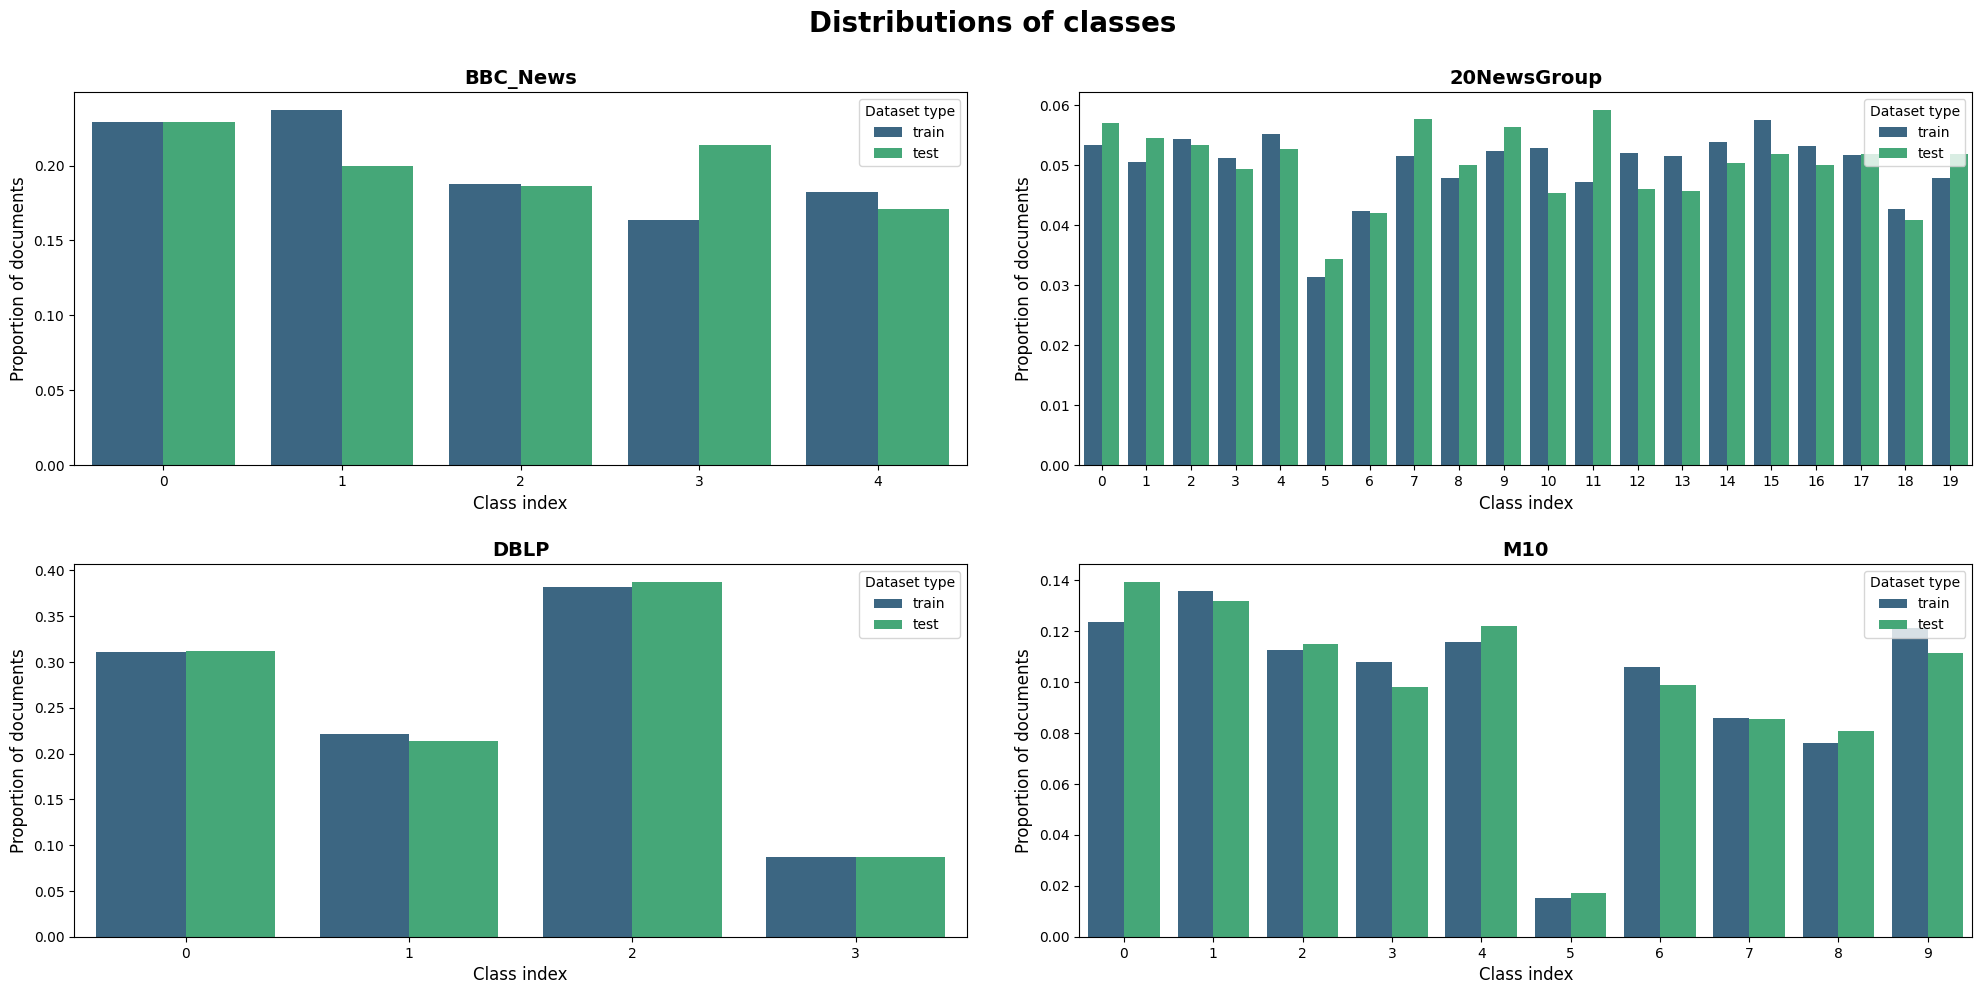

In [94]:
display_distributions_of_classes(['BBC_News', '20NewsGroup', 'DBLP', 'M10'])

In [95]:
def display_distribution_of_documents_length(datasets_names: list, bins: list, xlims: list):
    """ Displays the distribution of documents length for each dataset.

    Args:
        datasets_names (list): List of dataset names.
        bins (list): List of bins for each dataset.
        xlims (list): List of xlims for each dataset.
    """
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle('Distribution of documents length', fontsize=20, fontweight='bold')
    fig.tight_layout(pad=5.0, rect=[-0.01, -0.04, 1.03, 1.07])

    x, y = 0, 0

    for i, dataset_name in enumerate(datasets_names):
        df = pd.read_csv(f'./data/{dataset_name}/documents.csv')

        train_df = df[df['dataset_type'] == 'train']
        test_df = df[df['dataset_type'] == 'test']

        sns.histplot(train_df['document'].apply(lambda x: len(x.split())), bins=bins[i], ax=axs[x, y], kde=True, stat='density', label='Train', color=sns.color_palette('viridis', n_colors=2)[0])
        sns.histplot(test_df['document'].apply(lambda x: len(x.split())), bins=bins[i], ax=axs[x, y], kde=True, stat='density', label='Test', color=sns.color_palette('viridis', n_colors=2)[1])

        axs[x, y].set_title(dataset_name, fontsize=14, fontweight='bold')
        axs[x, y].set_xlabel('Number of words', fontsize=12)
        axs[x, y].set_ylabel('Number of documents', fontsize=12)
        axs[x, y].set_xlim(0, xlims[i])
        axs[x, y].legend(title='Dataset type')

        if y == 1:
            x += 1
            y = 0
        else:
            y += 1

    fig.savefig('../figures/datasets/distribution_of_documents_length.png', dpi=300)

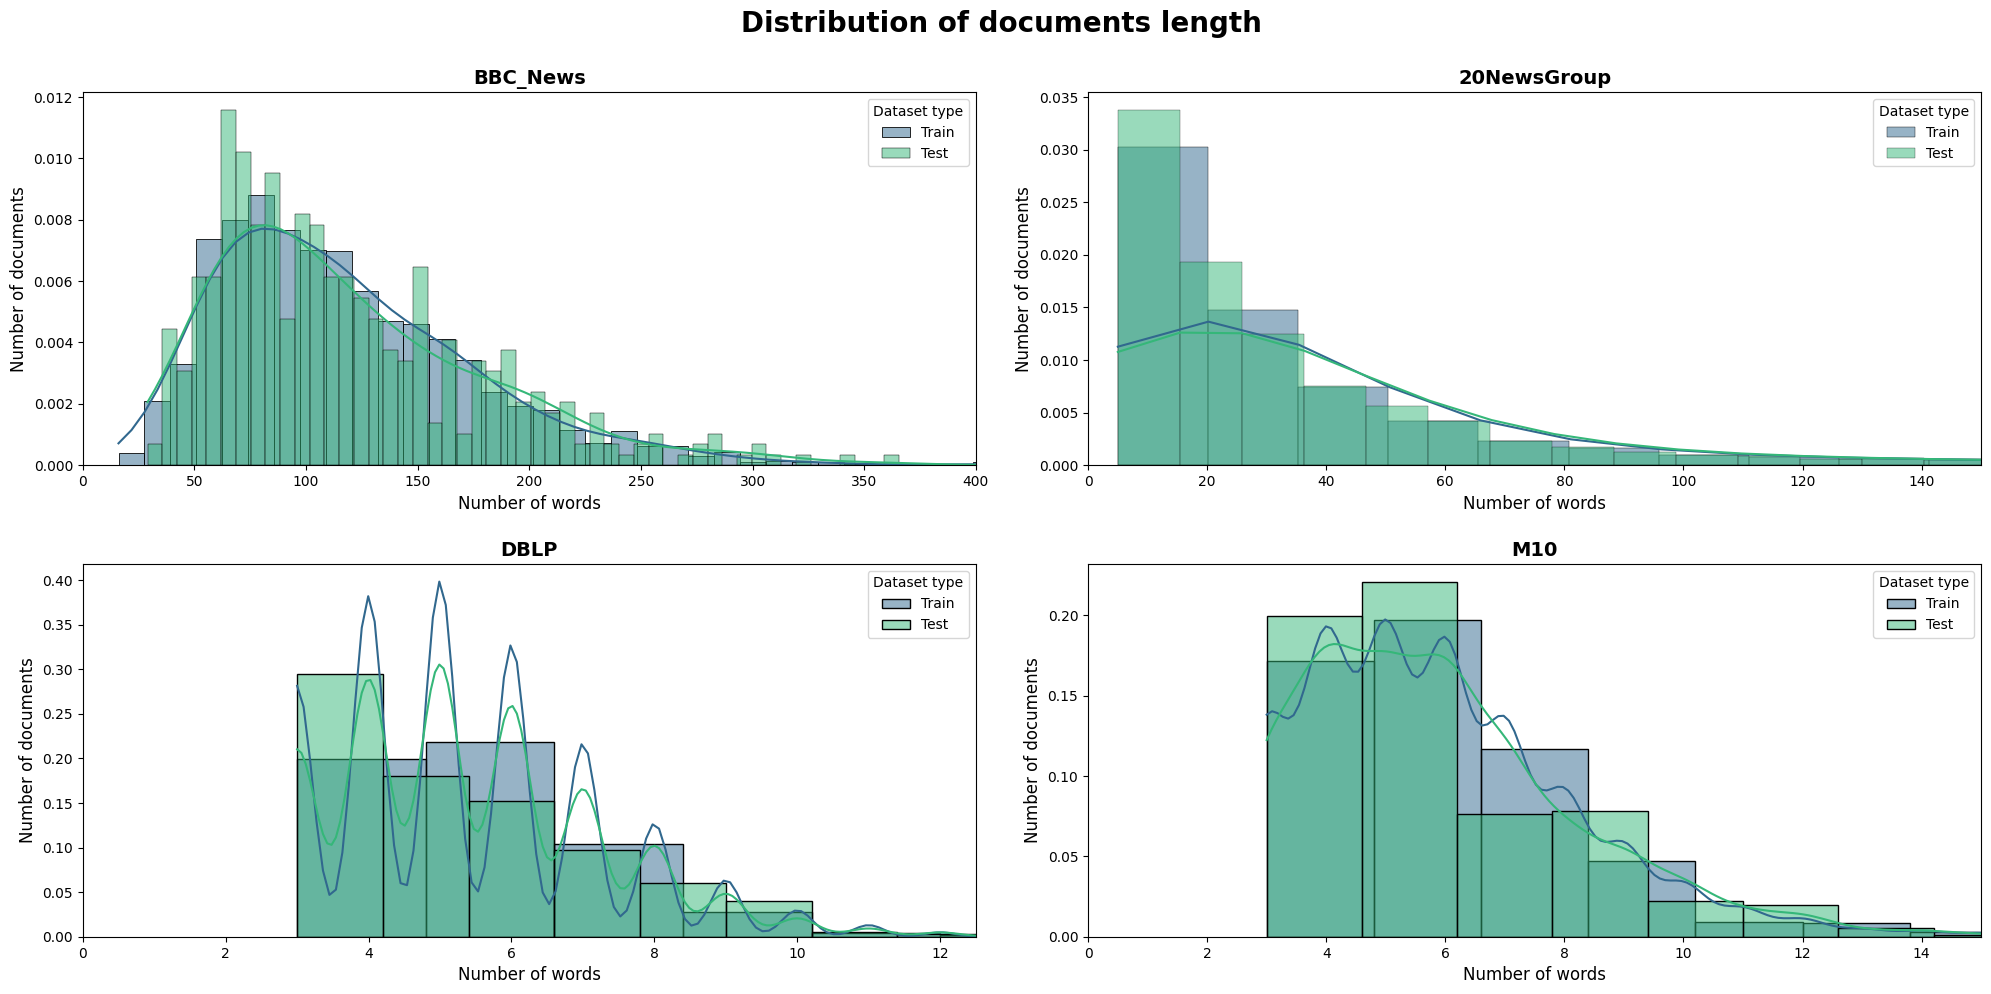

In [96]:
display_distribution_of_documents_length(['BBC_News', '20NewsGroup', 'DBLP', 'M10'], bins=[100, 200, 10, 10], xlims=[400, 150, 12.5, 15])

In [122]:
def display_most_frequent_words(datasets_names: list, n_words: int):
    """ Displays the most frequent words for each dataset.

    Args:
        datasets_names (list): List of dataset names.
        n_words (int): Number of words to display.
    """
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle('Most frequent words', fontsize=20, fontweight='bold')
    fig.tight_layout(pad=8.0, rect=[-0.03, -0.04, 1.06, 1.15])

    x, y = 0, 0

    for i, dataset_name in enumerate(datasets_names):
        df = pd.read_csv(f'./data/{dataset_name}/documents.csv')

        most_frequent_words = df['document'].str.split(expand=True).stack().value_counts()[:n_words].index.tolist()
        count_most_frequent_words = df['document'].str.split(expand=True).stack().value_counts()[:n_words].tolist()
        sns.barplot(x=most_frequent_words, y=count_most_frequent_words, ax=axs[x, y], orient='v', color=sns.color_palette('viridis', n_colors=2)[0])

        axs[x, y].set_title(dataset_name, fontsize=14, fontweight='bold')
        axs[x, y].set_xlabel('Number of occurrences', fontsize=12)
        axs[x, y].set_ylabel('Word', fontsize=12)
        axs[x, y].xaxis.set_ticks(most_frequent_words)
        axs[x, y].set_xticklabels(most_frequent_words, rotation=45, ha='right')

        if y == 1:
            x += 1
            y = 0
        else:
            y += 1

    fig.savefig('../figures/datasets/most_frequent_words.png', dpi=300)

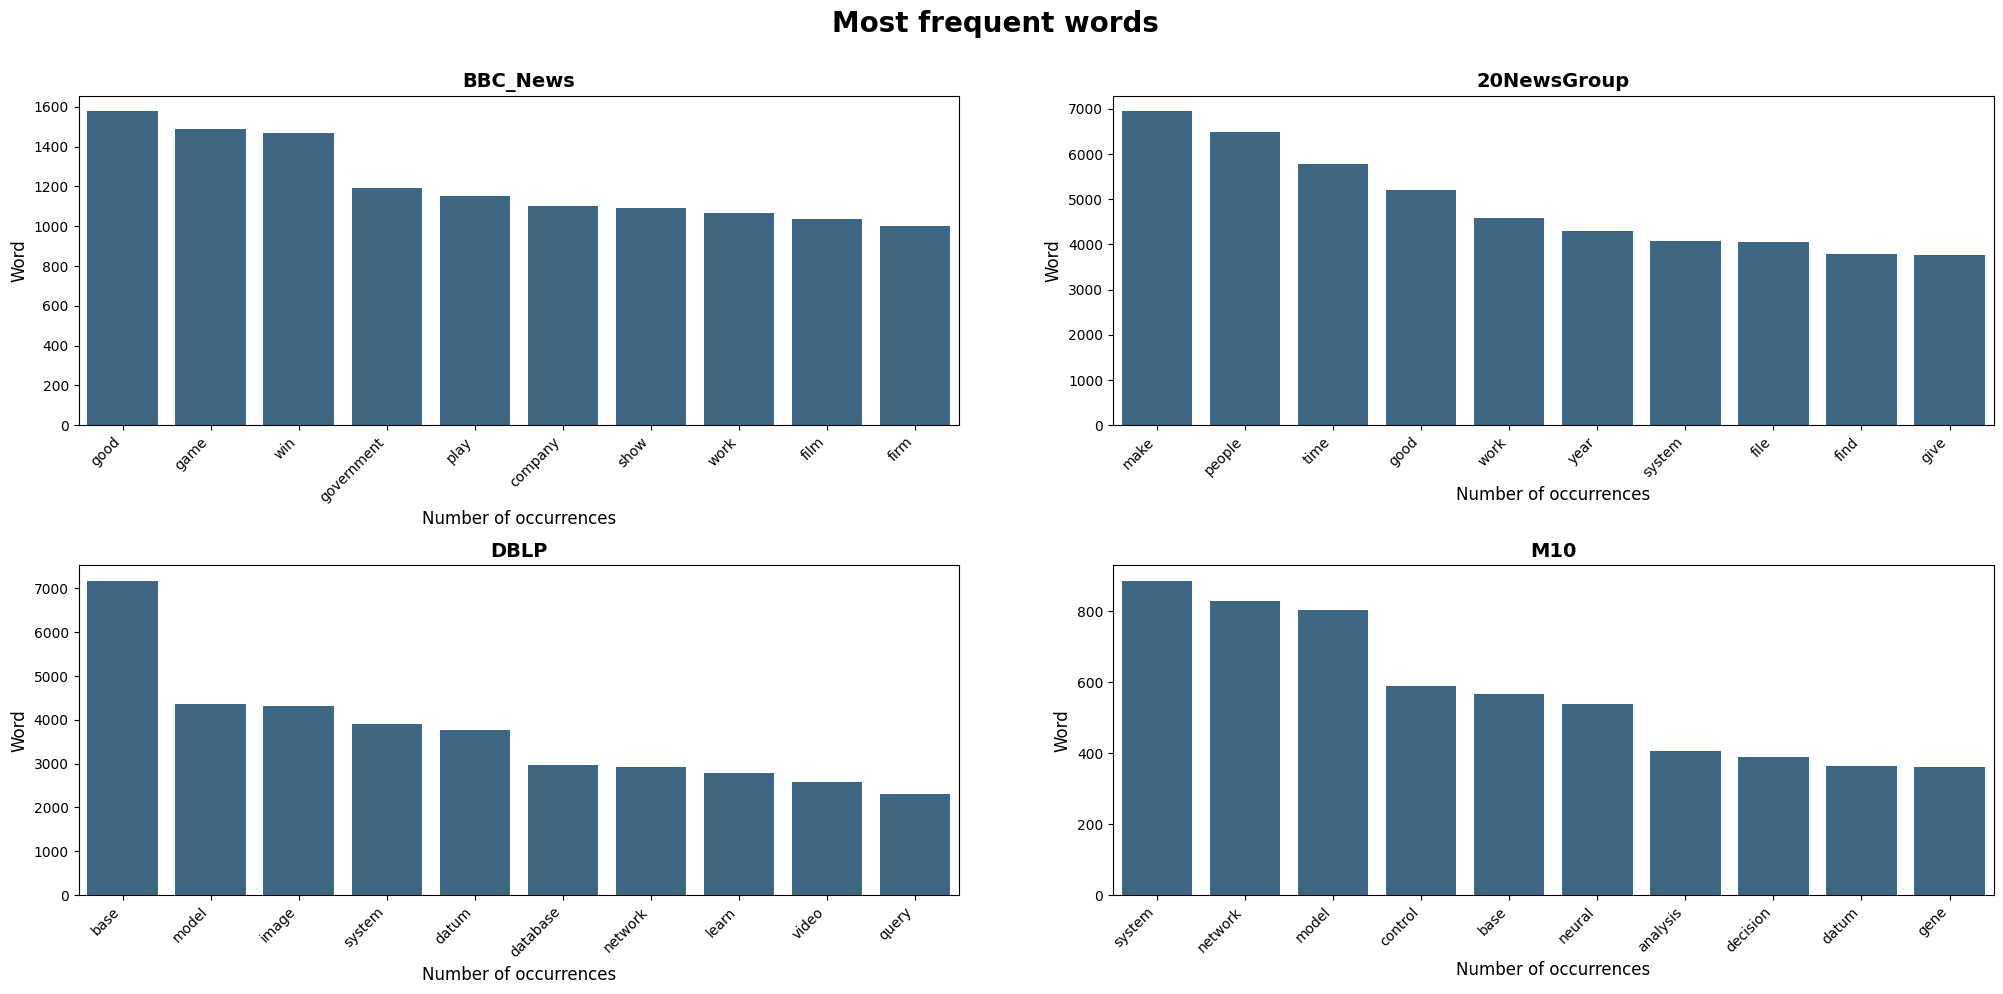

In [123]:
display_most_frequent_words(['BBC_News', '20NewsGroup', 'DBLP', 'M10'], n_words=10)

In [99]:
def display_distribution_of_words_occurence(datasets_names: list, bins: list, xlims: list):
    """ Displays the distribution of words occurence for each dataset.

    Args:
        datasets_names (list): List of dataset names.
        bins (list): List of bins for each dataset.
        xlims (list): List of xlims for each dataset.
    """
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle('Distribution of words occurence', fontsize=20, fontweight='bold')
    fig.tight_layout(pad=5.0, rect=[-0.01, -0.04, 1.03, 1.07])

    x, y = 0, 0

    for i, dataset_name in enumerate(datasets_names):
        df = pd.read_csv(f'./data/{dataset_name}/documents.csv')

        sns.histplot(df['document'].str.split(expand=True).stack().value_counts(), bins=bins[i], ax=axs[x, y], kde=True, stat='density', label='Train', color=sns.color_palette('viridis', n_colors=2)[0])

        axs[x, y].set_title(dataset_name, fontsize=14, fontweight='bold')
        axs[x, y].set_xlabel('Number of occurrences', fontsize=12)
        axs[x, y].set_ylabel('Number of words', fontsize=12)
        axs[x, y].set_xlim(0, xlims[i])

        if y == 1:
            x += 1
            y = 0
        else:
            y += 1

    fig.savefig('../figures/datasets/distribution_of_words_occurence.png', dpi=300)

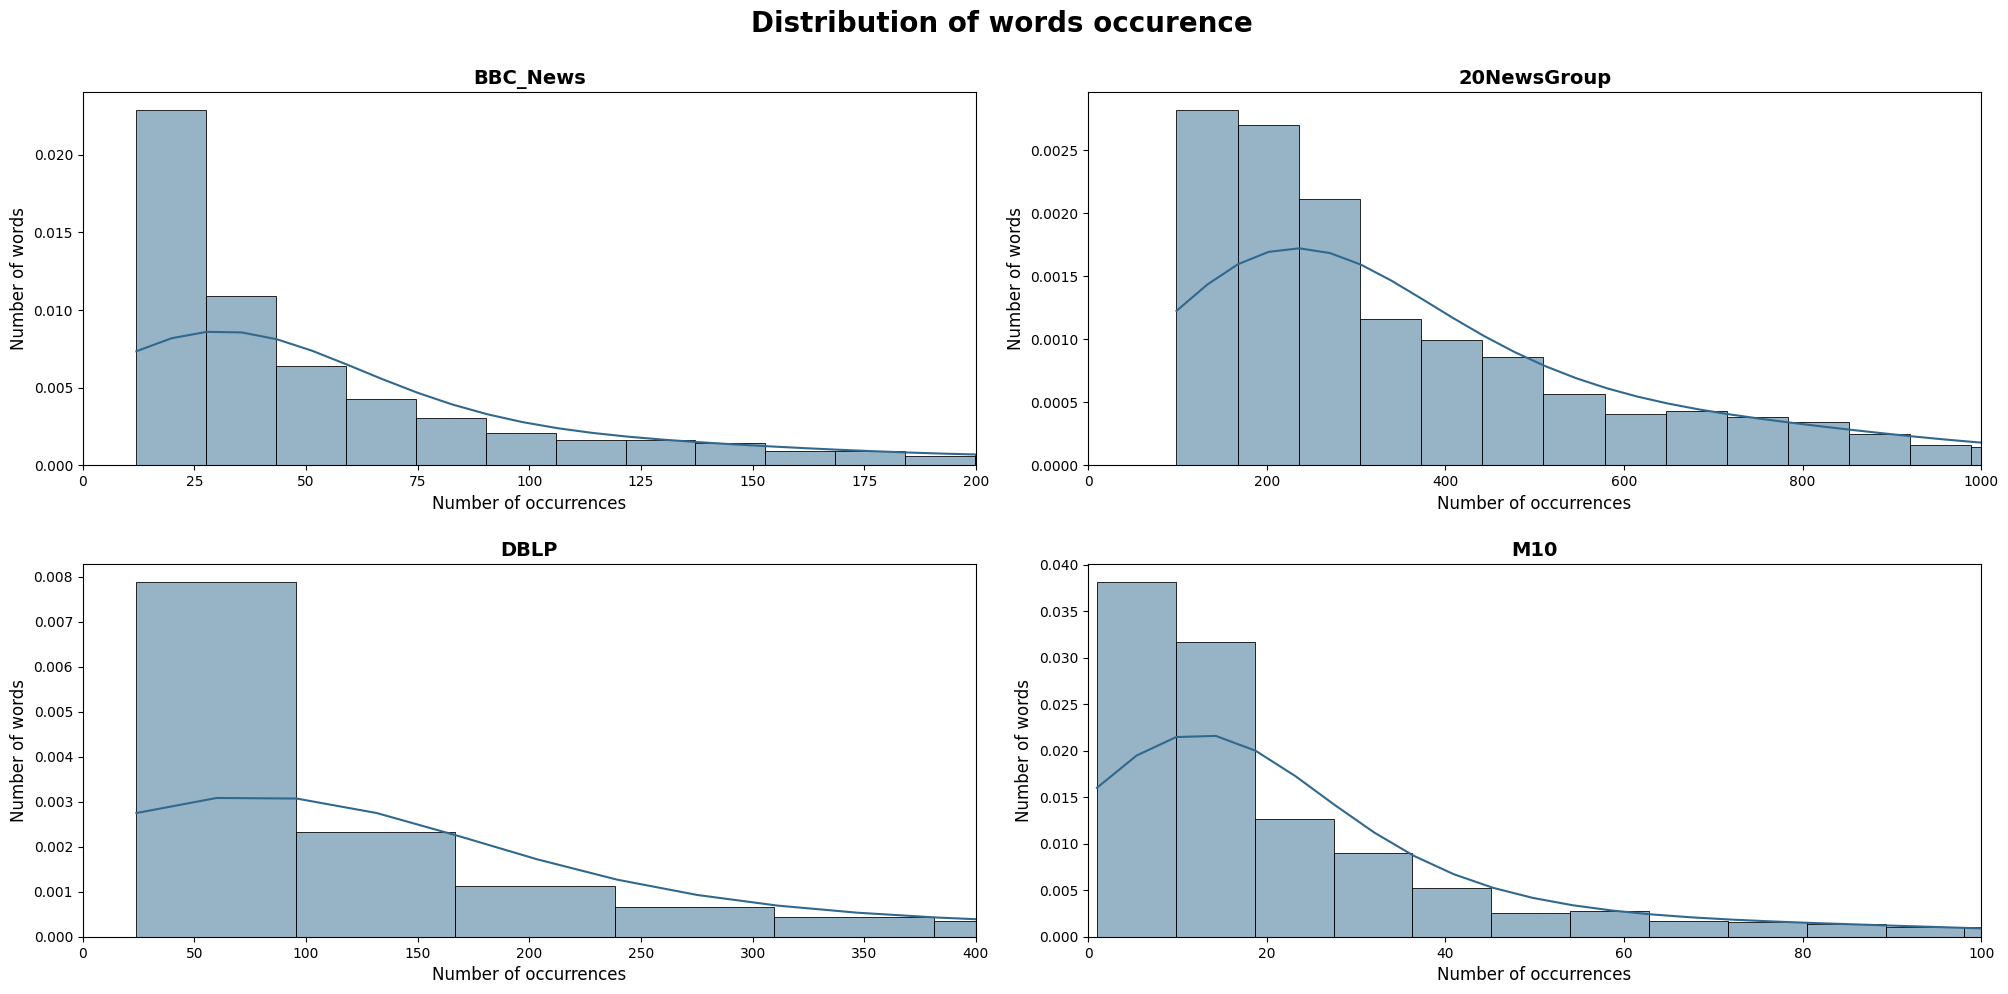

In [100]:
display_distribution_of_words_occurence(['BBC_News', '20NewsGroup', 'DBLP', 'M10'], bins=[100, 100, 100, 100], xlims=[200, 1000, 400, 100])